In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import*
from fastai.dataset import*

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects


In [3]:
import torch, torchvision
print("torch:", torch.__version__)
print("CUDA toolkit:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print(torch.backends.cudnn.version())

torch.cuda.set_device(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(0))

torch: 0.3.1
CUDA toolkit: 9.0.176
GPU available: True
torchvision: 0.2.1
7005
CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [4]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
PATH = Path('../data/pascal_2007')

In [6]:
trn_j = json.load((PATH/'train.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILENAME, ID, IMG_ID, CAT_ID,BBOX = 'file_name', 'id', 'image_id','category_id', 'bbox'


In [7]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILENAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]] 

IMG_PATH = Path('../data/pascal_2007/train')
trn_IMG_PATH = 'train'

In [8]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [30]:
# def show_img(im, figsize=None, ax=None):
#     if not ax: fig,ax = plt.subplots(figsize=figsize)
#     ax.imshow(im)
#     ax.set_xticks(np.linspace(0, 224, 8))
#     ax.set_yticks(np.linspace(0, 224, 8))
#     ax.grid()
#     ax.set_ytickslabel([])
#     ax.set_xtickslabel([])
#     return ax

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [10]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

### Multi Class

In [11]:
MC_CSV = PATH/'tmp/mc.csv'

In [12]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [13]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [14]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns = ['fn', 'clas'])
df.to_csv(MC_CSV, index=False)

In [15]:
f_model = resnet34
sz = 224
bs =64

In [16]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, MC_CSV, tfms=tfms)

In [17]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn =optim.Adam

In [18]:
lrf = learn.lr_find(1e-5, 100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   <lambda>                  
    0      1.49958    14.039322  0.4919    


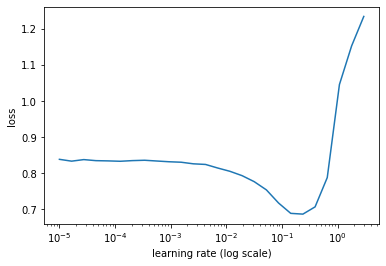

In [19]:
learn.sched.plot(0)

In [20]:
lr = 2e-2

In [21]:
learn.fit(lr,1, cycle_len=3, use_clr=(32,5))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   <lambda>                  
    0      0.32859    0.120702   0.9591    
    1      0.173499   0.077056   0.9747                    
    2      0.11578    0.074687   0.9748                    


[array([0.07469]), 0.9747999920845032]

In [22]:
lrs = np.array([lr/100, lr/10, lr])

In [23]:
learn.freeze_to(-2)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

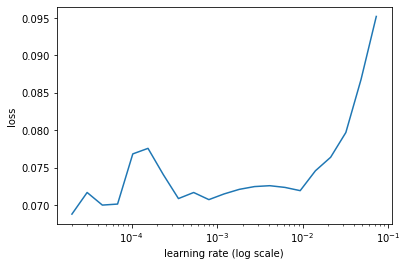

In [24]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [25]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr = (32,5))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   <lambda>                   
    0      0.080434   0.098073   0.9665    
    1      0.066841   0.092174   0.9707                     
    2      0.049362   0.085951   0.9712                     
    3      0.033465   0.08294    0.9746                     
    4      0.022357   0.081402   0.9753                     


[array([0.0814]), 0.9752999958992005]

In [26]:
learn.save('mclas')

In [27]:
learn.load('mclas')

In [28]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


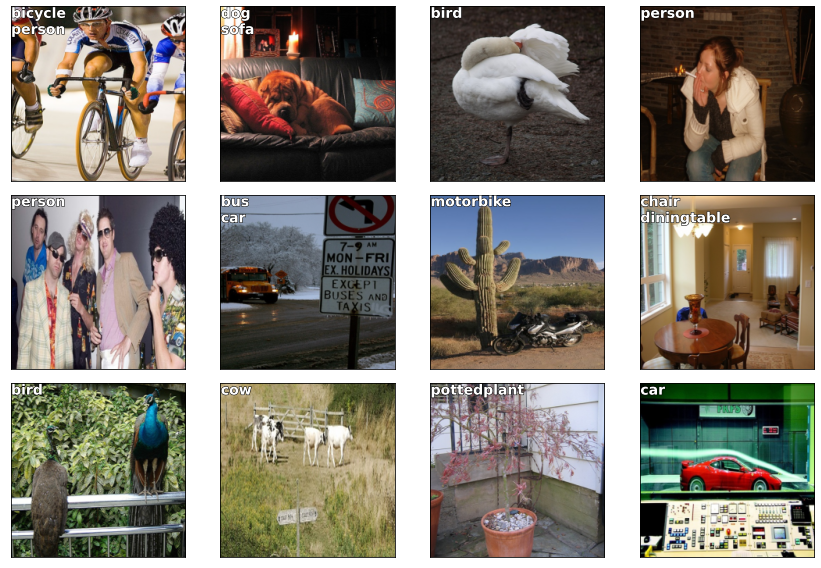

In [31]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>0.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0) , b)
plt.tight_layout()

### Bbox per cell